<a href="https://colab.research.google.com/github/dkalenov/ML-Trading/blob/2_supervised-learning/DL_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
# Data Management
import numpy as np
import pandas as pd

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Deep Learning
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt

### Data Extraction and Feature Engineering

In [4]:
# Load data from saved file
df = pd.read_csv("https://raw.githubusercontent.com/dkalenov/ML-Trading/1_unsupervised-learning/pair_trade.csv")
df.drop(columns="Date", inplace=True)
df["lrets_a1"] = np.log(df["Asset1"] / df["Asset1"].shift(1))
df["lrets_a2"] = np.log(df["Asset2"] / df["Asset2"].shift(1))
df["lrets_a1_roll"] = df["lrets_a1"].rolling(window=21).mean()
df["lrets_a2_roll"] = df["lrets_a2"].rolling(window=21).mean()
df["a1_prod_rets"] = df["lrets_a1"].cumsum()
df["a2_prod_rets"] = df["lrets_a2"].cumsum()
df.dropna(inplace=True)
print("Length: ", len(df))
df.head(2)

Length:  1700


,Asset1,Asset2,Spread,ZScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets
21,48.837223,30.187937,-6.446061,-0.791428,0.001312,0.004108,0.000727,0.000786,0.015264,0.016509
22,48.462242,29.639868,-5.817361,-0.423198,-0.007708,-0.018322,0.000360,-0.000439,0.007557,-0.001813


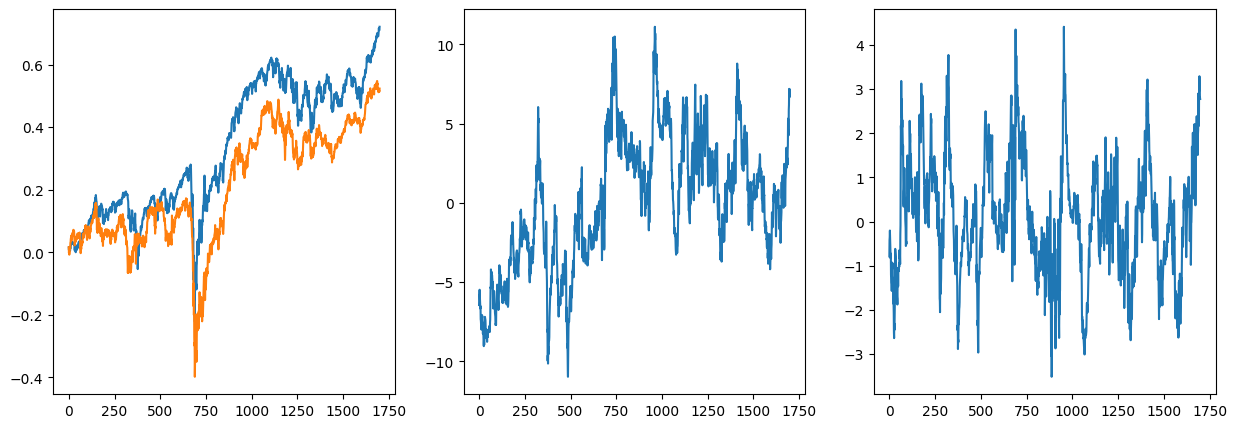

In [5]:
# Visualize Data
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(df["a1_prod_rets"].values)
plt.plot(df["a2_prod_rets"].values)

plt.subplot(1, 3, 2)
plt.plot(df["Spread"].values)

plt.subplot(1, 3, 3)
plt.plot(df["ZScore"].values)

In [6]:
# Add Target
future_step = 1
df["TARGET"] = 0
df.loc[df["Spread"].shift(-future_step) > 0, "TARGET"] = 1
df.dropna(inplace=True)
df.head(2)

,Asset1,Asset2,Spread,ZScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets,TARGET
21,48.837223,30.187937,-6.446061,-0.791428,0.001312,0.004108,0.000727,0.000786,0.015264,0.016509,0
22,48.462242,29.639868,-5.817361,-0.423198,-0.007708,-0.018322,0.000360,-0.000439,0.007557,-0.001813,0


In [7]:
# Split X and y
X_data = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
len(X_data), len(y)

(1700, 1700)

In [8]:
# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X_data)
X[:2]

array([[-1.39319354, -1.06518854, -1.55749757, -0.67537417,  0.06935295,
         0.27947749,  0.11520963,  0.16551118, -1.51688974, -1.06987347],
       [-1.41996623, -1.14714453, -1.40611307, -0.39528133, -0.62901575,
        -1.36696491, -0.01607207, -0.25249996, -1.55402985, -1.17018381]])

### Dataload Structuring

In [9]:
# Dataset Class
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
        self.length = self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    def __len__(self):
        return self.length

trainset = dataset(X, y)
trainloader = DataLoader(trainset, batch_size=64, shuffle=False)

In [10]:
# Review X Data
trainloader.dataset.X[:2]

tensor([[-1.3932, -1.0652, -1.5575, -0.6754,  0.0694,  0.2795,  0.1152,  0.1655,
         -1.5169, -1.0699],
        [-1.4200, -1.1471, -1.4061, -0.3953, -0.6290, -1.3670, -0.0161, -0.2525,
         -1.5540, -1.1702]])

In [11]:
# Review y Data
trainloader.dataset.y[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Build Neural Net

In [12]:
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

### Train Neural Net

In [15]:
# Hyperparams
learning_rate = 0.01
epochs = 200

# Model, Optimizer, Loss
model = Net(input_shape=X.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

In [16]:
# Forward Loop
losses = []
accur = []
for i in range(epochs):
    for j, (X_train, y_train) in enumerate(trainloader):

        # Calculate ouput
        output = model(X_train)

        # Calculate loss
        loss = loss_fn(output, y_train.reshape(-1, 1))

        # Calculate accuracy
        predicted = model(torch.tensor(X, dtype=torch.float32))
        acc = (predicted.detach().numpy().round() == y).mean()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print Results
        if i % 100 == 0:
            losses.append(loss)
            accur.append(acc)
            print(f"Epoch: {i}, Loss: {loss}, Accuracy: {acc}")

Epoch: 0, Loss: 0.6385112404823303, Accuracy: 0.5097467128027682
Epoch: 0, Loss: 0.6049193143844604, Accuracy: 0.4862615916955017
Epoch: 0, Loss: 0.5297157168388367, Accuracy: 0.4835681660899654
Epoch: 0, Loss: 0.45996221899986267, Accuracy: 0.4835294117647059
Epoch: 0, Loss: 0.47366809844970703, Accuracy: 0.4835294117647059
Epoch: 0, Loss: 0.7159709930419922, Accuracy: 0.4835294117647059
Epoch: 0, Loss: 0.1467701494693756, Accuracy: 0.4835294117647059
Epoch: 0, Loss: 0.12778010964393616, Accuracy: 0.4835294117647059
Epoch: 0, Loss: 0.47393354773521423, Accuracy: 0.4835294117647059
Epoch: 0, Loss: 0.12282688915729523, Accuracy: 0.4835294117647059
Epoch: 0, Loss: 1.378154993057251, Accuracy: 0.4835294117647059
Epoch: 0, Loss: 2.7820019721984863, Accuracy: 0.4835294117647059
Epoch: 0, Loss: 2.0097525119781494, Accuracy: 0.4835294117647059
Epoch: 0, Loss: 1.6622956991195679, Accuracy: 0.4835294117647059
Epoch: 0, Loss: 0.8191535472869873, Accuracy: 0.4836262975778547
Epoch: 0, Loss: 0.762